<script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script> 
<script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3.0.1/es5/tex-mml-chtml.js"></script>

# Figure S1 through S5: Fragmentation analysis of released muropeptide compounds.
This code prepares the plots as found in **Figure S1** through **Figure S5**.
- Irnov Irnov designed original experiment and collected all data.
- Joshua w. McCausland analyzed data and wrote code.

**All of these supplemental figures are made in one plot/analysis chunk at the end.**

In [1]:
import numpy as np
import pandas as pd
from pymzml.run import Reader
from matplotlib import pyplot as plt,ticker,lines
import seaborn as sns
plt.rcParams["font.family"] = "Arial" #Set global font to arial
import glob,os
import warnings
warnings.filterwarnings("ignore")
from scipy.signal import find_peaks,peak_widths

def refine_mass(df,ppm = 20,mass_to_search = 0):
    low_mass = mass_to_search - (ppm*mass_to_search/1e6)
    high_mass = mass_to_search + (ppm*mass_to_search/1e6)
    result = df.apply(lambda row: np.sum(row.peaks[np.where(np.logical_and(row.mz >= low_mass, row.mz <= high_mass))]) if row.peaks[np.where(np.logical_and(row.mz > low_mass, row.mz < high_mass))].shape[0] > 0 else 0,axis=1)
    return result

CB_color_cycle = {
    'blue':    '#377eb8',
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00',
} 



This takes the raw mzML files and converts them to pandas dataframes, similar to other code in this Github package. This is a unique case, for I added an additional variable "ms_level" to find and plot the MS2 results in this code.

In [ ]:
experiment_directory = '/Volumes/Data_06/Previous_member_B/Irnov Irnov/Scientist-Stanford/Data/LCMS/Data/QTOF/PolarC18/2022/20220503-PolarC18-MSMS/*.mzML'

FileList = glob.glob(experiment_directory)
for file in FileList:
    run = Reader(file)
    filename = os.path.basename(file).removesuffix('.mzML')
    run_df = pd.DataFrame({'scanID': [key for key in run.info['offset_dict'].keys() if str(key).isnumeric()]})
    run_df['time'] = run_df.scanID.apply(lambda row: run[row].scan_time_in_minutes())
    run_df['mz'] = run_df.scanID.apply(lambda row: run[row].mz)
    run_df['peaks'] = run_df.scanID.apply(lambda row: run[row].centroidedPeaks)
    run_df['peaks'] = run_df.peaks.apply(lambda row: np.column_stack(row)[1] if row.shape[0] > 0 else row)
    run_df['ms_level'] = run_df.scanID.apply(lambda row: run[row].ms_level)
    run_df['precursors'] = run_df.scanID.apply(lambda row: run[row].selected_precursors)
    run_df.to_pickle(f'pickle_data/{filename}.pkl')
run_df

To give room to tinker and find the right windows to display for plotting and analysis, this is a "global_parameters" section. Here, you can set the following.
- time_window: When should the EIC be plotted for display.
- peak_window: What peak should be highlighted for consideration and MS2 plotting (if there is more than one EIC peak to analyze)
- collision energy: What collision energy was used for this particular molecule in the experiment.
- adduct: in the event of detecting a different [M+H], specify here. Our molecules are all [M+H]+.
- pg_file: Because of overlapping run times, the same samples were run twice in two different files, but with different collision energies. The relevant pg file (0/1) is noted for each. 
- bar_width. Some samples have more spectra peaks than others. This allows us to fine-tune the width to make them equally presentable.
- xlim: Similar to bar_width. Allows us to tune the graphs for presentation.

In [4]:
global_parameters = {
    'AEOAAG': {
        'time_window': [1.5,3],
        'peak_window': [2.1,2.3],
        'Collision energy': 20,
        'adduct': 'mz_plus_1',
        'pg_file': 0,
        'bar_width': 40,
        'xlim': [125,600]
    },
    'AEOAA': {
        'time_window': [1.3,2.5],
        'peak_window': [1.55,1.75],
        'Collision energy': 10,
        'adduct': 'mz_plus_1',
        'pg_file': 1,
        'bar_width': 100,
        'xlim': [125,600]
    },
    'ZAEOAAG_left': {
        'time_window': [8,10],
        'peak_window': [8.45,8.7],
        'Collision energy': 30,
        'adduct': 'mz_plus_1',
        'pg_file': 1,
        'bar_width': 110,
        'xlim': [200,1100]
    },
    'ZAEOAAG_middle': {
        'time_window': [8,10],
        'peak_window': [8.95,9.2],
        'Collision energy': 30,
        'adduct': 'mz_plus_1',
        'pg_file': 0,
        'bar_width': 120,
        'xlim': [200,1100]
    },
    'ZAEOAAG_right': {
        'time_window': [8,10],
        'peak_window': [9.3,9.6],
        'Collision energy': 30,
        'adduct': 'mz_plus_1',
        'pg_file': 1,
        'bar_width': 110,
        'xlim': [200,1100]
    },
    'ZAEOG': {
        'time_window': [8,9],
        'peak_window': [8.275,8.45],
        'Collision energy': 30,
        'adduct': 'mz_plus_1',
        'pg_file': 0,
        'bar_width': 100,
        'xlim': [200,860]
    },
    'Z': {
        'time_window': [7,8],
        'peak_window': [7.25,7.5],
        'Collision energy': 10,
        'adduct': 'mz_plus_1',
        'pg_file': 0,
        'bar_width': 100,
        'xlim': [100,500]
    }
}

Iterate through the PG species to plot and make EICs and mz spectra.

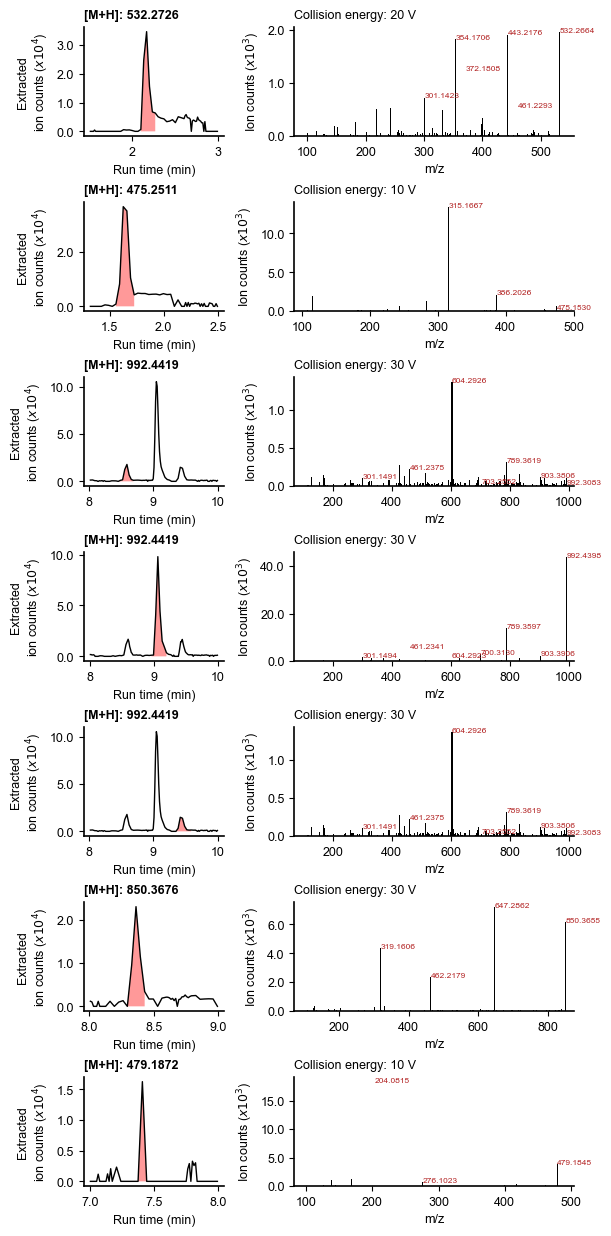

In [5]:
experiment_directory = '//mothership2.stanford.edu/Common/Science communication/Manuscripts/Papers/2024/Bb PG shedding/Draft_figures/SourceData/FigS1/pickle_data'
species_to_plot = ['AEOAAG','AEOAA','ZAEOAAG','ZAEOG','Z']


def y_fmt(x, y):
    return f'{(x/1e4):<2.1f}'.format(x).split('e')[0]

reference_df = pd.read_pickle('included_small_datasets/muropeptide_reference_df.pkl').drop_duplicates()
reference_df = reference_df[reference_df.Species.isin(species_to_plot)]
frag_df = pd.read_excel('included_small_datasets/pg_mol_fragmentation.xlsx')
frag_df = frag_df[frag_df.label_for_fig == 1]

filelist = glob.glob(f'{experiment_directory}/*.pkl')
file = filelist[0]

run_df = pd.DataFrame()
idx = 0
for file in filelist:
    temp_df = pd.read_pickle(file)
    temp_df['pg_file'] = np.repeat(idx,temp_df.shape[0])
    run_df = pd.concat([run_df,temp_df])
    idx += 1

for _,row in reference_df.iterrows():
    run_df[row.Species] = refine_mass(run_df,mass_to_search=row.mz_plus_1,ppm=20)

fig,axs = plt.subplots(nrows = len(global_parameters.keys()),ncols = 2,figsize=[6,1.75*len(global_parameters.keys())],layout = 'constrained',width_ratios=[0.5,1])

for _ax,key in zip(axs.T[0],global_parameters.keys()):
    _species = key.split('_')[0]
    _param = global_parameters[key]
    mz_value = reference_df[reference_df.Species == _species][_param['adduct']].values[0]
    
    ms1 = run_df[(run_df.pg_file == _param['pg_file']) & (run_df.ms_level == 1)]
    temp_df = ms1[ms1.time.between(_param['time_window'][0],_param['time_window'][1])]
    sns.lineplot(data=temp_df,x='time',y=_species,ax=_ax,linewidth=1,color='black')
    _ax.set_title(f'[M+H]: {mz_value:.4f}',fontsize=9,weight='bold',loc='left')
    signal = ms1[ms1.time.between(_param['peak_window'][0],_param['peak_window'][1])]
    _ax.fill_between(signal.time,signal[_species],alpha = 0.4,color ='red',edgecolor=None)

    _ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
    _ax.set_ylabel('Extracted\nion counts ($x10^4$)',fontsize=9)
    _ax.set_xlabel('Run time (min)',fontsize=9)

def y_fmt(x, y):
    return f'{(x/1e3):<2.1f}'.format(x).split('e')[0]

for _ax,key in zip(axs.T[1],global_parameters.keys()):
    _species = key.split('_')[0]
    _param = global_parameters[key]
    collision_energy = _param['Collision energy']

    ms1 = run_df[(run_df.pg_file == _param['pg_file']) & (run_df.ms_level == 1)]
    ms2 =run_df[(run_df.pg_file == _param['pg_file']) & (run_df.ms_level == 2)]
    

    temp_frag = frag_df[frag_df.species == _species]
    mz_value = reference_df[reference_df.Species == _species][_param['adduct']].values[0]
    temp_df = ms1[ms1.time.between(_param['time_window'][0],_param['time_window'][1])]
    rt_idx = temp_df[temp_df[_species] == temp_df[_species].max()].time.values[0]
    max_point = pd.DataFrame(ms2[ms2.time > rt_idx].iloc[0]).T
    max_point = max_point.explode(column=['mz','peaks'])
    max_point = max_point[(max_point.mz <= mz_value)]
    sns.barplot(data=max_point,x='mz',y='peaks',ax=_ax,color='black',native_scale=True,width=_param['bar_width'])
    for frag in temp_frag.fragment.values:
         row = max_point.iloc[(max_point['mz']-frag).abs().argsort()[:1]]
         _ax.text(row.mz,row.peaks,f'{row.mz.values[0]:.4f}',fontsize=6,color='firebrick') 
    _ax.set_xlim(right = mz_value+25)
    xlims = _ax.get_xlim()
    ylims = _ax.get_ylim()
    xscale = xlims[1] - (xlims[1] - xlims[0])/1.01
    yscale = ylims[1] - (ylims[1] - ylims[0])/6
    _ax.set_title(f'Collision energy: {collision_energy} V',fontsize=9,loc='left')
    _ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
    _ax.set_ylabel('Ion counts ($x10^3$)',fontsize=9)
    _ax.set_xlabel('')
    _ax.set_xlabel('m/z',fontsize=9)


for _ax in axs.ravel():
    _ax.spines[['right','top']].set_visible(False)
    _ax.spines[['left','bottom']].set_linewidth(1.2)
    _ax.tick_params(axis='both',labelsize=9)